# Visualization

Welcome to the cooltools visualization notebook!

Visualization is a crucial part of analyzing large-scale datasets. Before performing analyses of new Hi-C datasets, it is highly recommend to visualize the data. This notebook contains tips and tricks for visualization of coolers using cooltools.

Current topics:

* [Inspecting C-data stored in coolers](#Inspecting-C-data)
* [Visualizing C-data with matplotlib](#Visualizing-C-data)
* [Balancing: filtering bins, biases](#Balancing)
* [Coverage: cis/total profiles](#Coverage)
* [Smoothing, interpolation, and adaptive coarsegraining](#smoothing)

Future topics:

* higlass-python
* translocations, structural variants 
* visualizing matrices for other organisms
    

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
import cooltools
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [3]:
#import python package for working with cooler files: https://github.com/open2c/cooler
import cooler

## Inspecting C data <a id='Inspecting-C-data'></a>

The file we just downloaded, test.mcool, contains Micro-C data from HFF cells for two chromosomes in a [multi-resolution mcool format](https://cooler.readthedocs.io/en/latest/schema.html?highlight=mcool#multi-resolution).

In [4]:
# to print which resolutions are stored in the mcool, use list_coolers
cooler.fileops.list_coolers('./test.mcool')

['/resolutions/1000',
 '/resolutions/10000',
 '/resolutions/100000',
 '/resolutions/1000000']

In [5]:
### to load a cooler with a specific resolution use the following syntax:
clr = cooler.Cooler('./test.mcool::resolutions/1000000')

### to print chromosomes and binsize for this cooler
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

chromosomes: ['chr2', 'chr17'], binsize: 1000000
chr2 : (0, 243)
chr17 : (243, 327)


Coolers store pairwise contact frequencies in sparse format, which can be fetched on demand as dense matrices. `clr.matrix` returns a matrix selector. The selector supports Python slice syntax `[]` and a `.fetch()` method. 
Slicing `clr.matrix()` with `[:]` fetches all bins in the cooler. Fetching can return either  balanced, or corrected, contact frequences `(balance=True)`, or raw counts prior to bias removal `(balance=False)`. 

In genome-wide C data for mammalian cells in interphase, the following features are typically observed:

* Higher contact frequencies within a chromosome as opposed to between chromosomes; this is consistent with observations of chromosome territories. See [below](#coverage).

* More frequent contacts between regions at shorter genomic separations. Characterizing this is explored in more detail in the [contacts_vs_dist](https://github.com/open2c/open2c_examples/blob/master/contacts_vs_distance.ipynb) notebook.

* A plaid pattern of interactions, termed compartments. Characterizing this is explored in more detail in the [compartments](https://github.com/open2c/open2c_examples/blob/master/???.ipynb) notebook. 

Each of these features are visible below.

## Visualizing C data <a id='Visualizing-C-data'></a>

### Plotting raw counts 

First, we plot raw counts with a linear colormap thresholded at 500 counts for the entire cooler. Note that the number of counts per cooler depends on the sequencing depth of the experiment, and a different threshold may be needed to see the same features.

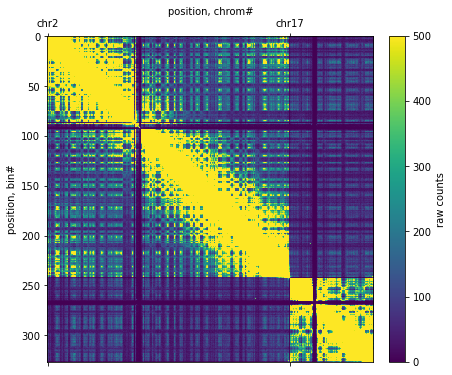

In [6]:
f, ax = plt.subplots(
    figsize=(7,6))
im = ax.matshow((clr.matrix(balance=False)[:]),vmax=500); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')
ax.set(xticks=chromstarts, xticklabels=clr.chromnames,
       xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

### Plotting subregions

Below, we fetch and plot an individual chromosome (left) and a region of a chromosome (right) using `clr.fetch()`

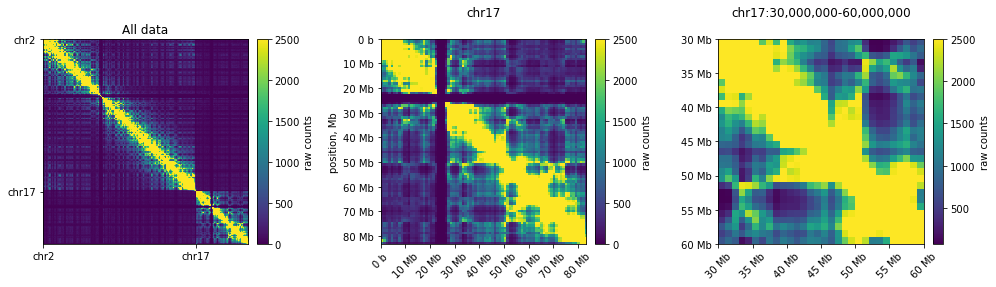

In [7]:
# to plot ticks in terms of megabases we use the EngFormatter 
# https://matplotlib.org/gallery/api/engineering_formatter.html
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)

ax = axs[0]
im = ax.matshow(clr.matrix(balance=False)[:], vmax=2500); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('chr17'),
    vmax=2500, 
    extent=(0,clr.chromsizes['chr17'], clr.chromsizes['chr17'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('chr17', y=1.08)
ax.set_ylabel('position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 30_000_000, 60_000_000
region = ('chr17', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    vmax=2500, 
    extent=(start, end, end, start)
); 
ax.set_title(f'chr17:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
format_ticks(ax)
plt.tight_layout()

### Logarithmic color scale

Since C data has a high dynamic range, we often plot the data in log-scale. This enables simultaneous visualization of features near and far from the diagonal in a consistent colorscale. Note that regions with no reported counts are evident as white stripes at both centromeres. This occurs because reads are not uniquely mapped to these highly-repetitive regions. These regions are masked before [matrix balancing](#balancing).

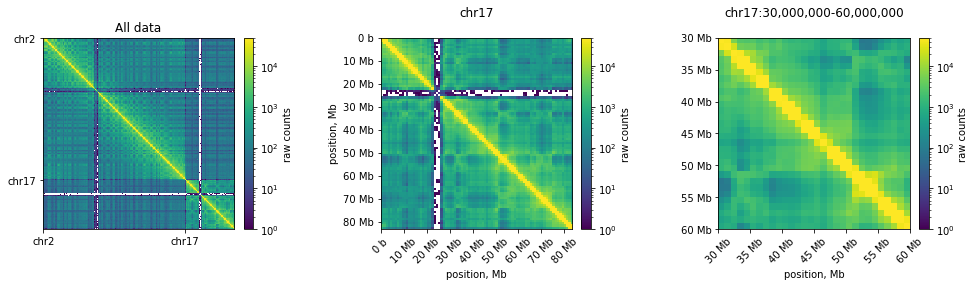

In [8]:
# plot heatmaps at megabase resolution with 3 levels of zoom in log-scale with a consistent colormap#
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)
bp_formatter = EngFormatter('b')
norm = LogNorm(vmax=50_000)

ax = axs[0]
im = ax.matshow(
    clr.matrix(balance=False)[:], 
    norm=norm,
) 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('chr17'),
    norm=norm,
    extent=(0,clr.chromsizes['chr17'], clr.chromsizes['chr17'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('chr17', y=1.08)
ax.set(ylabel='position, Mb', xlabel='position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 30_000_000, 60_000_000
region = ('chr17', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    norm=norm,
    extent=(start, end, end, start)
); 
ax.set_title(f'chr17:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set(xlabel='position, Mb')
format_ticks(ax)
plt.tight_layout()

### Colormaps
`cooltools.lib.plotting` registers a set of colormaps that are useful for visualizing C data.
In particular, the `fall` colormap (inspired by [colorbrewer](https://colorbrewer2.org/#type=sequential&scheme=YlOrRd&n=9)) offers a high dynamic range, linear, option for visualizing Hi-C matrices. This often displays features more clearly than red colormaps.


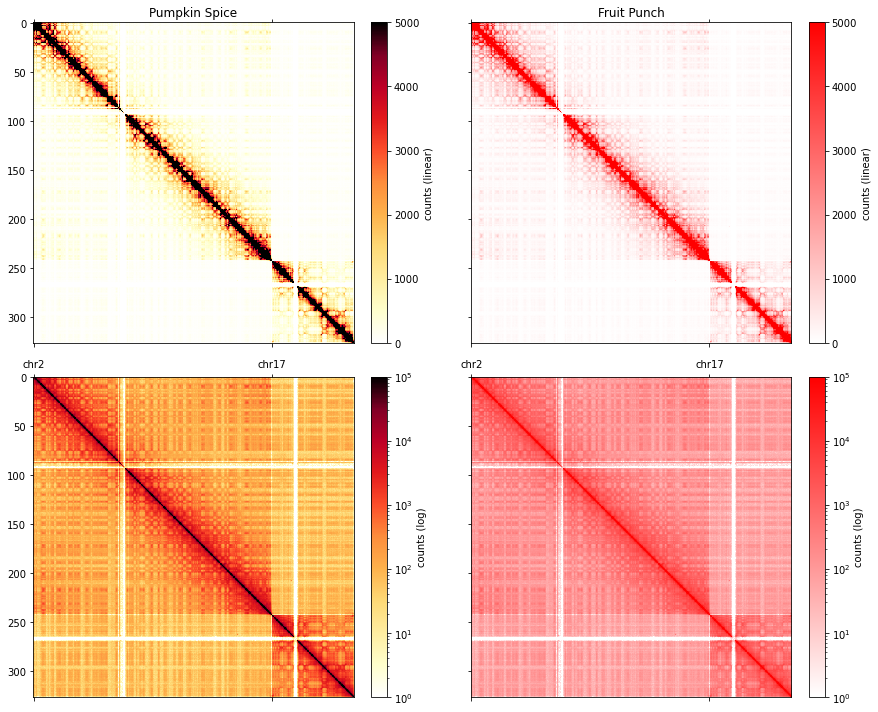

In [9]:
### plot the corrected data in fall heatmap and compare to the white-red colormap ###
### thanks for the alternative collormap naming to https://twitter.com/HiC_memes/status/1286326919122825221/photo/1###
import cooltools.lib.plotting

vmax = 5000
norm = LogNorm(vmin=1, vmax=100_000)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2, 
    ncols=2,
    sharex=True, sharey=True)

ax = axs[0, 0]
ax.set_title('Pumpkin Spice')
im = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[0, 1]
ax.set_title('Fruit Punch')
im3 = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap=fruitpunch); 
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 0]
im = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 1]
im3 = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap=fruitpunch); 
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()

The utility of fall colormaps becomes more noticeable at higher resolutions and higher degrees of zoom.

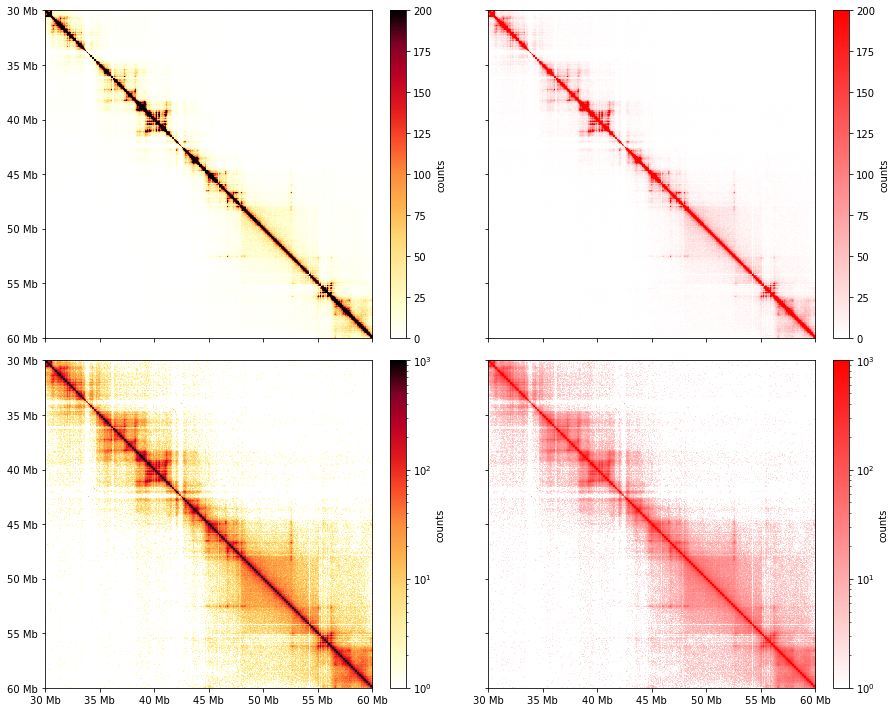

In [10]:
### plot the corrected data in fall heatmap ###
import cooltools.lib.plotting
clr_10kb = cooler.Cooler('./test.mcool::resolutions/10000')

region = 'chr17:30,000,000-35,000,000'
extents = (start, end, end, start)
norm = LogNorm(vmin=1, vmax=1000)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2, 
    ncols=2,
    sharex=True, 
    sharey=True
)

ax = axs[0, 0]
im = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap='fall',
    vmax=200,
    extent=extents
); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts');

ax = axs[0, 1]
im2 = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch, 
    vmax=200,
    extent=extents
); 
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts');

ax = axs[1, 0]
im = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap='fall',
    norm=norm,
    extent=extents
); 
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='counts');

ax = axs[1, 1]
im2 = ax.matshow(
    clr_10kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch, 
    norm=norm,
    extent=extents
); 
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts');

for ax in axs.ravel():
    format_ticks(ax, rotate=False)
plt.tight_layout()

## Balancing <a id='Balancing'></a>

When `(balance=True)` is passed to cooler.matrix(), this applies correction weights calculated from matrix balancing. Matrix balancing (also called iterative correction and KR normalization) removes multiplicative biases, which constitute the majority of known biases, from C data.
By default, the rows & columns of the matrix are  normalized to sum to one (note that the colormap scale differs after balancing). Biases, also called weights for normalization, are stored in the `weight` column of the bin table given by `clr.bins()`.

In [11]:
clr.bins()[:3]

,chrom,start,end,weight
0,chr2,0,1000000,0.002441
1,chr2,1000000,2000000,0.002435
2,chr2,2000000,3000000,0.002728


Before balancing, cooler also applies filters to remove low-coverage bins (note that peri-centromeric bins are completely removed in the normalized data). Filtered bins are stored as `np.nan` in the weights. 

Matrices appear visually smoother after removal of biases. Smoother matrices are expected for chromosomes, as adjacent regions along a chromosome are connected and should only slowly vary in their contact frequencies with other regions. 

<ipython-input-12-682685800adc>:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


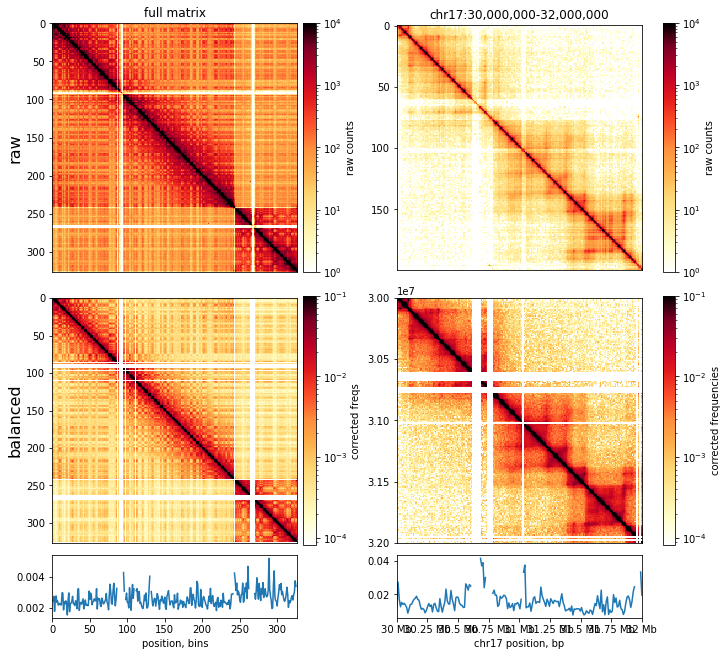

In [12]:
### plot the raw and corrected data in logscale ###
from mpl_toolkits.axes_grid import make_axes_locatable

plt_width=4
f, axs = plt.subplots(
    figsize=( plt_width+plt_width+2, plt_width+plt_width+1),
    ncols=4,
    nrows=3,
    gridspec_kw={'height_ratios':[4,4,1],"wspace":0.01,'width_ratios':[1,.05,1,.05]},
    constrained_layout=True
)

norm = LogNorm(vmax=0.1)
norm_raw = LogNorm(vmin=1, vmax=10_000)

ax = axs[0,0]
im = ax.matshow(
    clr.matrix(balance=False)[:], 
    norm=norm_raw,  
    cmap='fall',
    aspect='auto'
); 
ax.xaxis.set_visible(False)
ax.set_title('full matrix')
ax.set_ylabel('raw', fontsize=16)

cax = axs[0,1]
plt.colorbar(im, cax=cax, label='raw counts')

ax = axs[1,0]
im = ax.matshow(
    clr.matrix()[:], 
    norm=norm,  
    cmap='fall',
); 
ax.xaxis.set_visible(False)
ax.set_ylabel('balanced', fontsize=16)

cax = axs[1,1]
plt.colorbar(im, cax=cax, label='corrected freqs')

ax1 = axs[2,0]
weights = clr.bins()[:]['weight'].values
ax1.plot(weights)
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_xlabel('position, bins')

ax1 = axs[2,1]
ax1.set_visible(False)



start = 30_000_000
end = 32_000_000
region = ('chr17', start, end)

ax = axs[0,2]
im = ax.matshow(
        clr_10kb.matrix(balance=False).fetch(region), 
    norm=norm_raw,  
    cmap='fall'
); 
ax.set_title(f'chr17:{start:,}-{end:,}')
ax.xaxis.set_visible(False)

cax = axs[0,3]
plt.colorbar(im, cax=cax, label='raw counts');

ax = axs[1,2]
im = ax.matshow(
    clr_10kb.matrix().fetch(region), 
    norm=norm,  
    cmap='fall',
    extent=(start, end, end, start)
); 
ax.xaxis.set_visible(False)

cax = axs[1,3]
plt.colorbar(im, cax=cax, label='corrected frequencies');

ax1 = axs[2,2]
weights = clr_10kb.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start, end, len(weights)),
    weights
)
format_ticks(ax1, y=False, rotate=False)
ax1.set_xlim(start, end);
ax1.set_xlabel('chr17 position, bp')

ax1 = axs[2,3]
ax1.set_visible(False)


## Coverage <a id='Coverage'></a>

Contact matrices often display varible tendency to make contacts within versus between chromosomes. 
This can be calculated in cooltools with `cooltools.coverage` and is often plotted as a ratio of (cis_coverage/total_coverage). Note that the total coverge is similar to, but distinct from, the iteratively calculated balancing weights (see above).

Text(0, 0.5, 'coverage ratio')

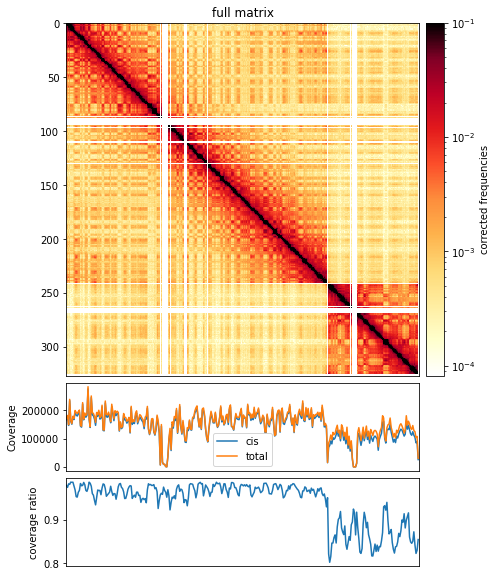

In [13]:
cis_coverage, tot_coverage = cooltools.coverage(clr)

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix()[:], 
    norm=norm,  
    cmap='fall'
); 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_title('full matrix')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
weights = clr.bins()[:]['weight'].values
ax1.plot( cis_coverage, label='cis')
ax1.plot( tot_coverage, label='total')
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_ylabel('Coverage')
ax1.legend()
ax1.set_xticks([])

ax2 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax2.plot( cis_coverage/ tot_coverage)
ax2.set_xlim([0, len(clr.bins()[:])])
ax2.set_ylabel('coverage ratio')

## Smoothing & Interpolation <a id='smoothing'></a>
When working with C data at high resolution, it is often useful to smooth matrices. cooltools provides a method, `adaptive_coarsegrain`, which adaptively smoothing corrected matrices based on the number of counts in raw matrices. For visualization it is also often useful to interpolate over filtered out bins. 

/gpfs/igmmfs01/eddie/wendy-lab/ilia/cooltools/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


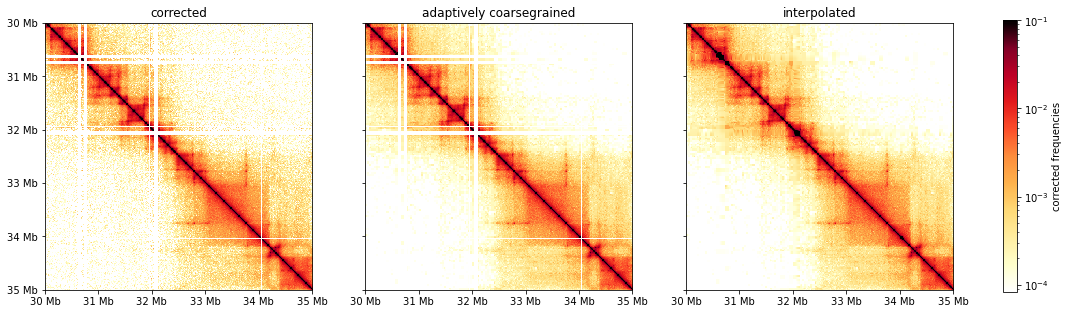

In [14]:
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

clr_10kb = cooler.Cooler('./test.mcool::resolutions/10000')
start = 30_000_000
end = 35_000_000
region = ('chr17', start, end)
extents = (start, end, end, start)

cg = adaptive_coarsegrain(clr_10kb.matrix(balance=True).fetch(region),
                              clr_10kb.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)

cgi = interp_nan(cg)

f, axs = plt.subplots(
    figsize=(18,5),
    nrows=1, 
    ncols=3,
    sharex=True, sharey=True)

ax = axs[0]
im = ax.matshow(clr_10kb.matrix(balance=True).fetch(region), cmap='fall', norm=norm, extent=extents)
ax.set_title('corrected')

ax = axs[1]
im2 = ax.matshow(cg, cmap='fall', norm=norm, extent=extents)
ax.set_title(f'adaptively coarsegrained')

ax = axs[2]
im3 = ax.matshow(cgi, cmap='fall', norm=norm, extent=extents)
ax.set_title(f'interpolated')

for ax in axs:
    format_ticks(ax, rotate=False)

plt.colorbar(im3, ax=axs, fraction=0.046, label='corrected frequencies')

In [15]:
### future:
# - yeast maps
# - translocations
# - higlass